# SnapATAC Peak Matrix Analysis

Using data processed by Laksshman, pmat using peaks from day-wise bulk + cluster-wise bulk combined. ChromVAR analysis as well.

**NOTE**: As of 6 Feb, the pmat are attached to snap files only at `/srv/scratch`. Moreover, the pmat attached using SnapTools most likely counts fragments in peaks. For correctness, we should count Tn5 shifted 5' ends of reads in peaks.

In [81]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 
library(scales)

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [83]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [84]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [85]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [86]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [87]:
x.sp

number of barcodes: 74838
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [88]:
dim(x.sp@pmat)

[1]  74838 467339

In [89]:
rm(x.sp.list); # free memory
gc()

used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    7450790  398.0   23093242  1233.4   36083192  1927.1
Vcells 1062877714 8109.2 4596919497 35071.8 8740305310 66683.3

In [90]:
x.sp = makeBinary(x.sp, mat="pmat");

In [91]:
# remove UMIs with few bins -- Omit this since they were already filtered at 5kb level.
# tempCov = Matrix::rowSums(x.sp@pmat)
# x.sp = x.sp[tempCov>1000, , mat="pmat"]
# x.sp

In [425]:
# remove UMIs with too many bins
tempCov = Matrix::rowSums(x.sp@pmat)
x.sp = x.sp[tempCov<10000, , mat="pmat"]
x.sp

number of barcodes: 63322
number of bins: 0
number of genes: 0
number of peaks: 436309
number of motifs: 453

In [92]:
# sampling few cells for speed (simplified analysis)
# sample_idx = sort(sample(seq(1,dim(x.sp@bmat)[1]), 10000))
# x.sp = x.sp[sample_idx,]
# x.sp

In [93]:
# OR keeping the same number of cells from each day
# fewest_per_day = min(table(x.sp@sample)) # TAKING HALVE
# print(fewest_per_day)

# idxs = c()
# for (d in DAYS) {
#     idxs = c(idxs, sample(which(x.sp@sample==d), fewest_per_day))
# }
# idxs = sort(idxs)

# table(x.sp@sample[idxs])

# x.sp = x.sp[idxs, ]

In [426]:
x.sp

number of barcodes: 63322
number of bins: 0
number of genes: 0
number of peaks: 436309
number of motifs: 453

## Filtering bins

In [95]:
black_list = read.table("../20200122_snapATAC/data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [96]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [ ]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [ ]:
# chr.exclude = seqlevels(x.sp@peak)[grep("random|chrM|chrUn", seqlevels(x.sp@peak))];
# idy = grep(paste(chr.exclude, collapse="|"), x.sp@peak);
# if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [ ]:
x.sp

In [ ]:
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

## Dim Reduction 

In [427]:
rowCovs = Matrix::rowSums(x.sp@pmat)

In [433]:
row.covs = log10(rowCovs+1);

LANDMARKS_PER_DAY = ceiling(16000/length(DAYS))
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [434]:
set.seed(1);
idx.landmark.ds = c()

for (d in DAYS) {
    idx.landmark.ds = c(idx.landmark.ds, 
                        sample(x = which(x.sp@sample==d), size = LANDMARKS_PER_DAY, prob = sampling_prob[which(x.sp@sample==d)])
                       )
}
idx.landmark.ds = sort(idx.landmark.ds);
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [435]:
table(x.landmark.sp@sample)


  D0  D10  D12  D14   D2   D4   D6   D8 
2000 2000 2000 2000 2000 2000 2000 2000 

In [436]:
# DID NOT PREVIOUSLY WORK OUT OF THE BOX SINCE bmat was hardcoded in trainRegression
# there was also a typo in runLDM.R last line of runDiffusionMapsExtension
# Changed it in my version /users/surag/software/R_packages/SnapATAC

In [437]:
x.landmark.sp = runDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="pmat", 
    num.eigs=50
);

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



In [438]:
x.query.sp = runDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="pmat"
  );

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: performing normalization ...

Epoch: projecting query cells to the reference ...

Epoch: Done



In [439]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT

# IMP: recompute since order has changed
rowCovs = Matrix::rowSums(x.sp@pmat)

In [440]:
max(x.landmark.sp@jmat@nmat)

[1] 3.750726

In [441]:
quantile(as.vector(x.landmark.sp@jmat@nmat), 0.99)

99% 
2.3228

In [442]:
rm(x.landmark.sp, x.query.sp); # free memory

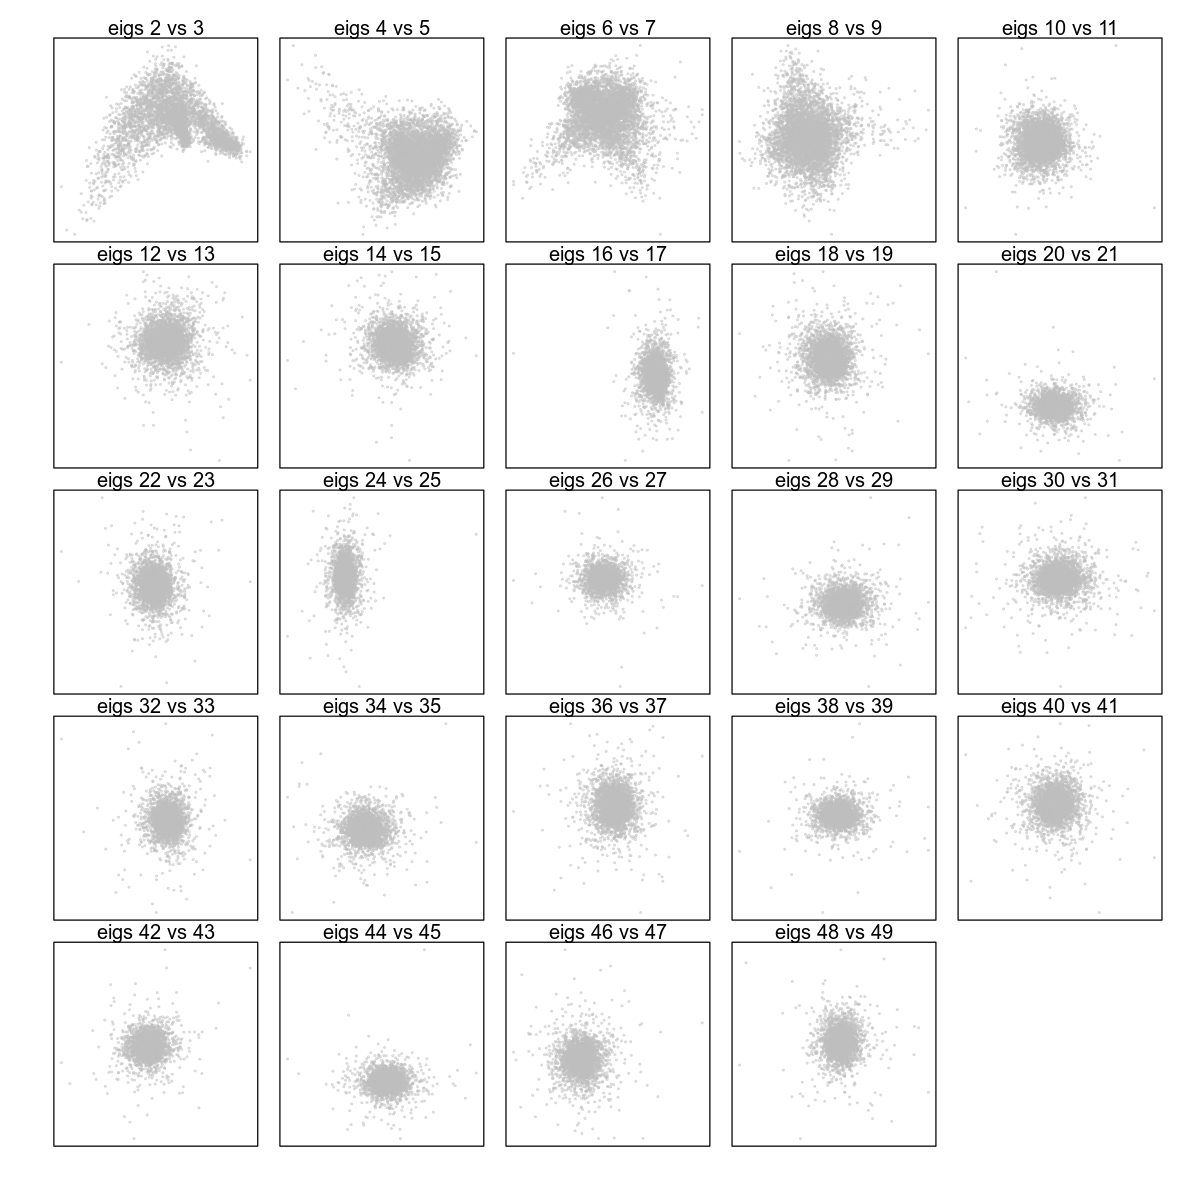

In [444]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [460]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:9,
    k=15
  );

In [446]:
library(leiden)

In [ ]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   seed.use=10
);
x.sp@metaData$cluster = x.sp@cluster;

In [ ]:
table(x.sp@cluster)

In [ ]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:9, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

In [ ]:
dim(x.sp@umap)

In [ ]:
# write features- can use for Trajectory inference
# NUM_EIGS = 9
# df = data.frame(x.sp@sample, x.sp@umap, x.sp@cluster, x.sp@smat@dmat[,1:NUM_EIGS])
# rownames(df) = paste(x.sp@sample, x.sp@barcode, sep='_')
# write.table(df, "./sessions/20200220_n74838/features.tsv", 
#             sep='\t', quote = F, row.names = T)

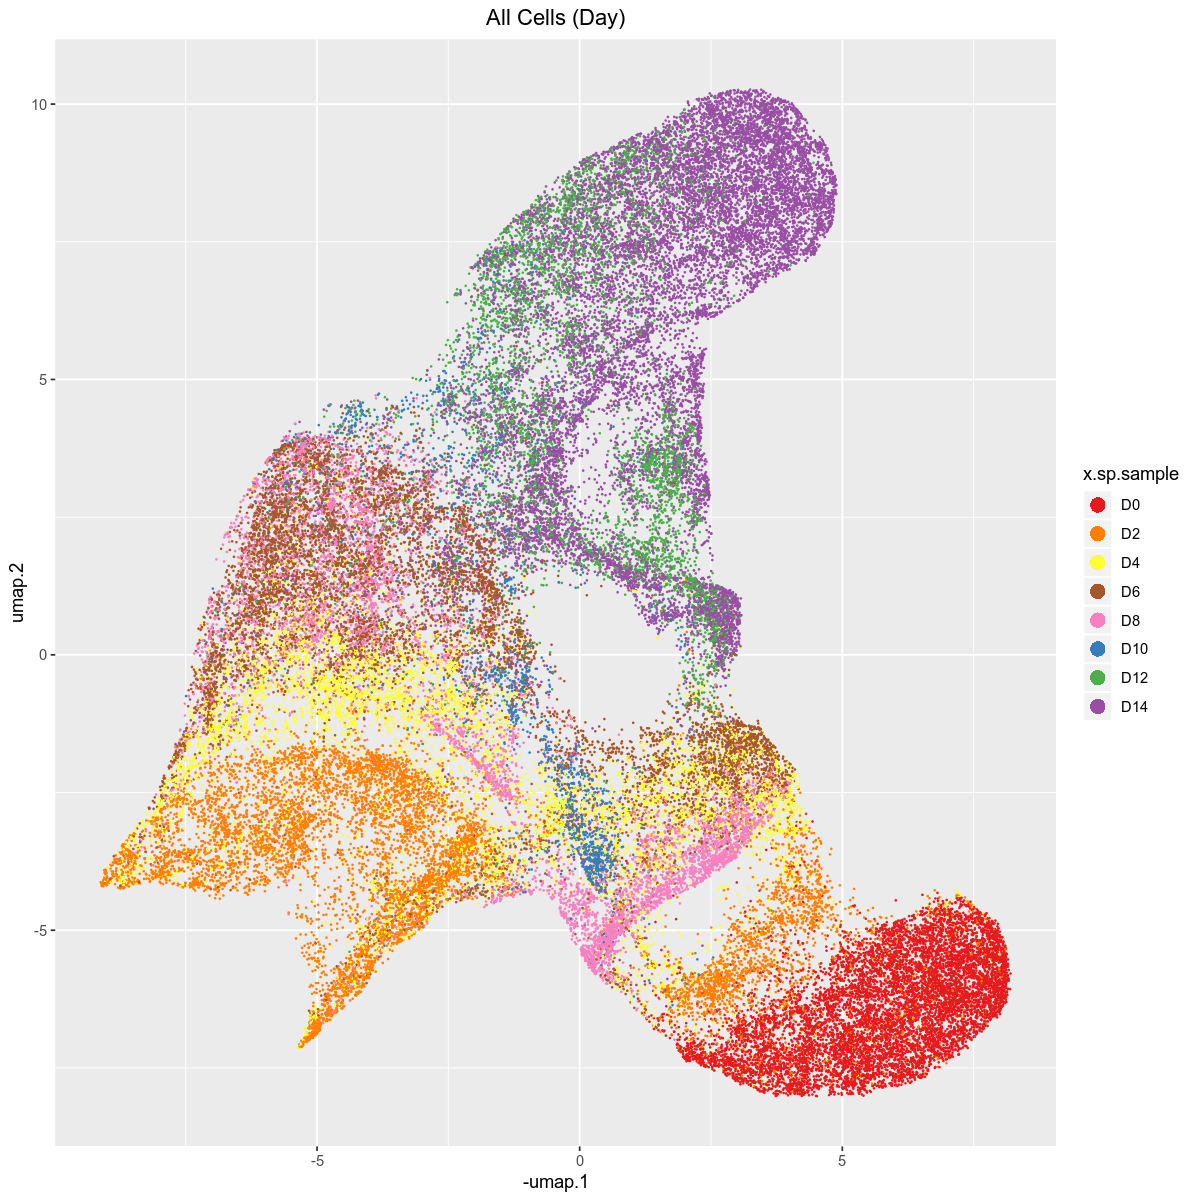

In [454]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[(df$x.sp.sample %in% c("D6","D8","D10", "D12")),],) +
geom_point(size=0.1, alpha=1, aes(x=-umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

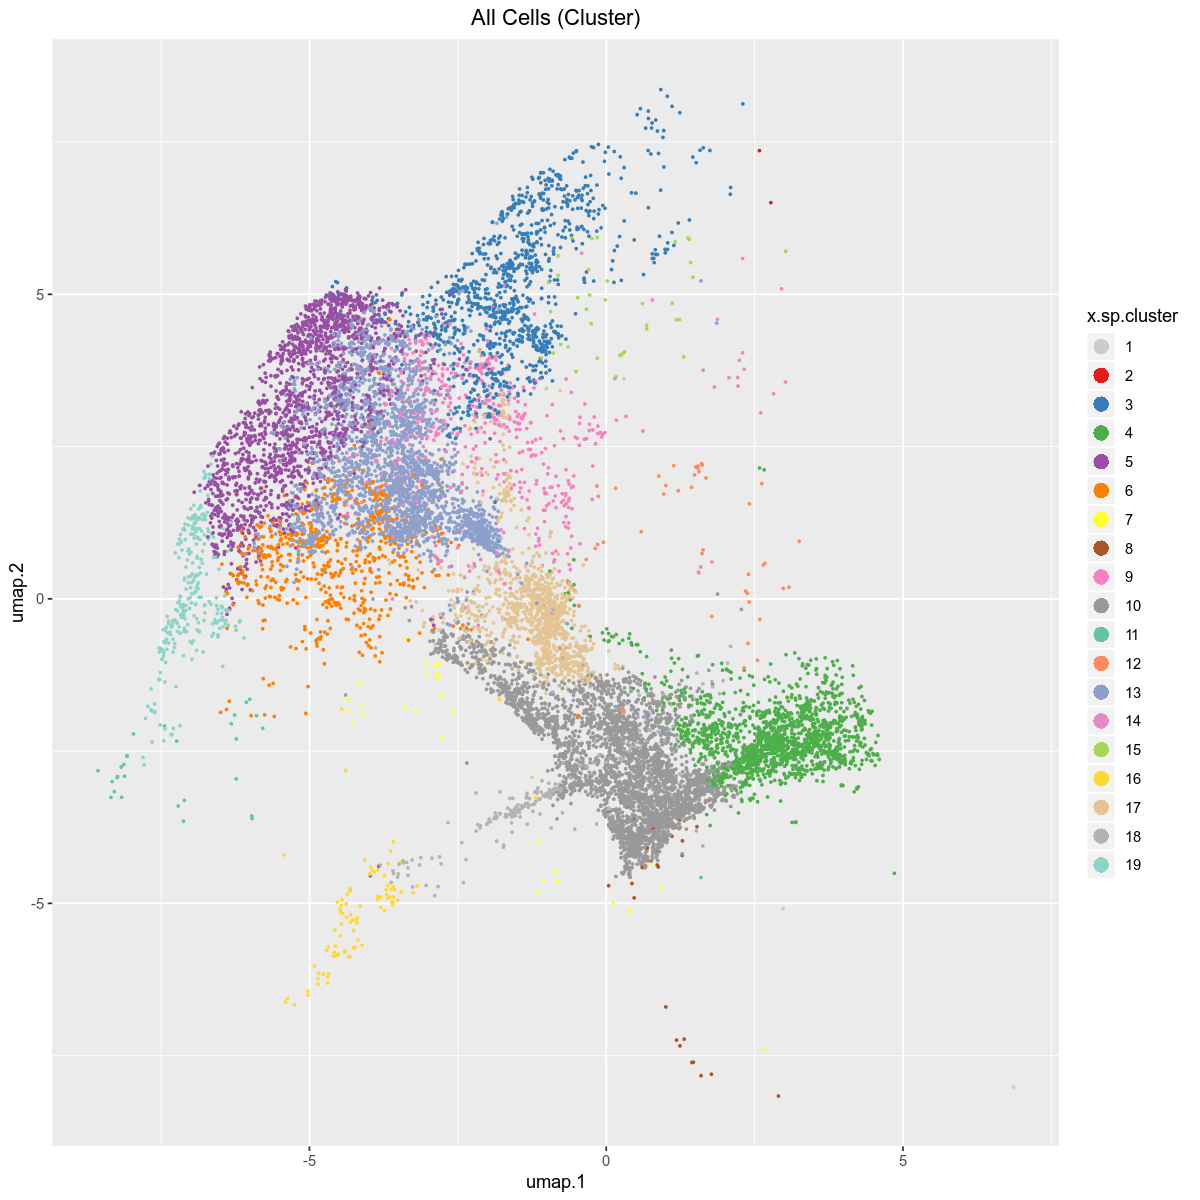

In [382]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

# ggplot(df, 
ggplot(df[(df$x.sp.sample %in% c("D6","D8","D10", "D12")),], 
       aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.4, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

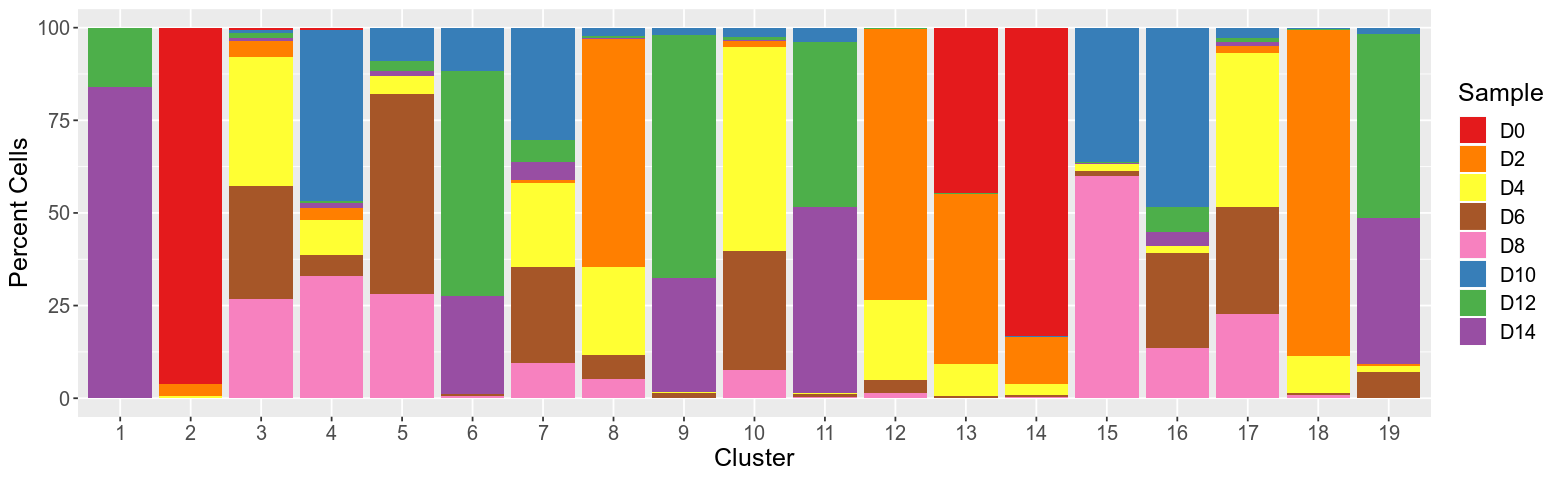

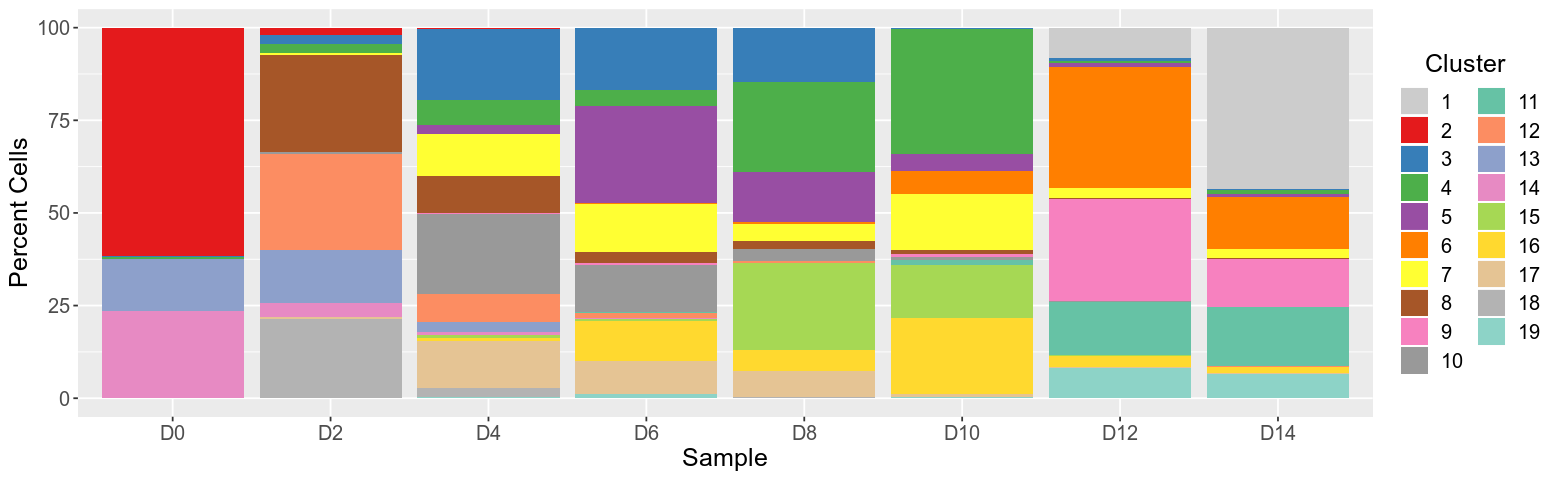

In [236]:
# TODO: clusters should be ordered such that similar ones are close in number and colour

# day-wise cluster membership + cluster-wise day membership
options(repr.plot.width = 13, repr.plot.height = 4)

sample_cluster_df = data.frame(sample=x.sp@sample, cluster=x.sp@cluster, count=1)

# count cells per sample x cluster
sample_cluster_cts = aggregate(.~sample+cluster, 
                               sample_cluster_df, 
                               sum)
# normalise per sample
sample_cts = aggregate(sample_cluster_df[,"count"], list(sample_cluster_df[,"sample"]), sum)
rownames(sample_cts) = sample_cts$Group.1
sample_cts$Group.1 = NULL

# frac of cluster per sample
sample_cluster_cts$frac_cluster = 100*sample_cluster_cts$count/sample_cts[sample_cluster_cts$sample, "x"]

# normalise per cluster
cluster_norm_cts = aggregate(sample_cluster_cts[,"frac_cluster"], list(sample_cluster_cts[,"cluster"]), sum)
rownames(cluster_norm_cts) = cluster_norm_cts$Group.1
cluster_norm_cts$Group.1 = NULL

# frac of day (after normalizing for number of cells per day) per sample
sample_cluster_cts$frac_day = 100*sample_cluster_cts$frac_cluster/cluster_norm_cts[sample_cluster_cts$cluster, "x"]

ggplot(data=sample_cluster_cts, aes(x=cluster, y=frac_day, fill=sample)) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Cluster") +
guides(fill = guide_legend(ncol=1, title="Sample", pos="center")) +
theme(text = element_text(size=15))

# Stacked barplot with multiple groups
ggplot(data=sample_cluster_cts, aes(x=factor(sample, levels=DAYS), y=frac_cluster, fill=cluster)) +
scale_fill_manual(values = col_vector[seq(45,74,1)]) +
geom_bar(stat="identity") +
ylab("Percent Cells") +
xlab("Sample") +
guides(fill = guide_legend(ncol=2, title="Cluster", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))


In [229]:
# Density plot

# options(repr.plot.width = 10, repr.plot.height = 10)

# df = data.frame(x.sp@umap, x.sp@sample)

# ggplot(df) +
# geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
# ggtitle("All Cells (Density)") + 
# theme(plot.title = element_text(hjust = 0.5))  

In [154]:
table(x.sp@sample[x.sp@cluster=="11"])


 D10  D12  D14   D4   D6   D8 
  48  873 2456    2   31    8 

In [ ]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@peak, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@pmat[,idy]) / Matrix::rowSums(x.sp@pmat);

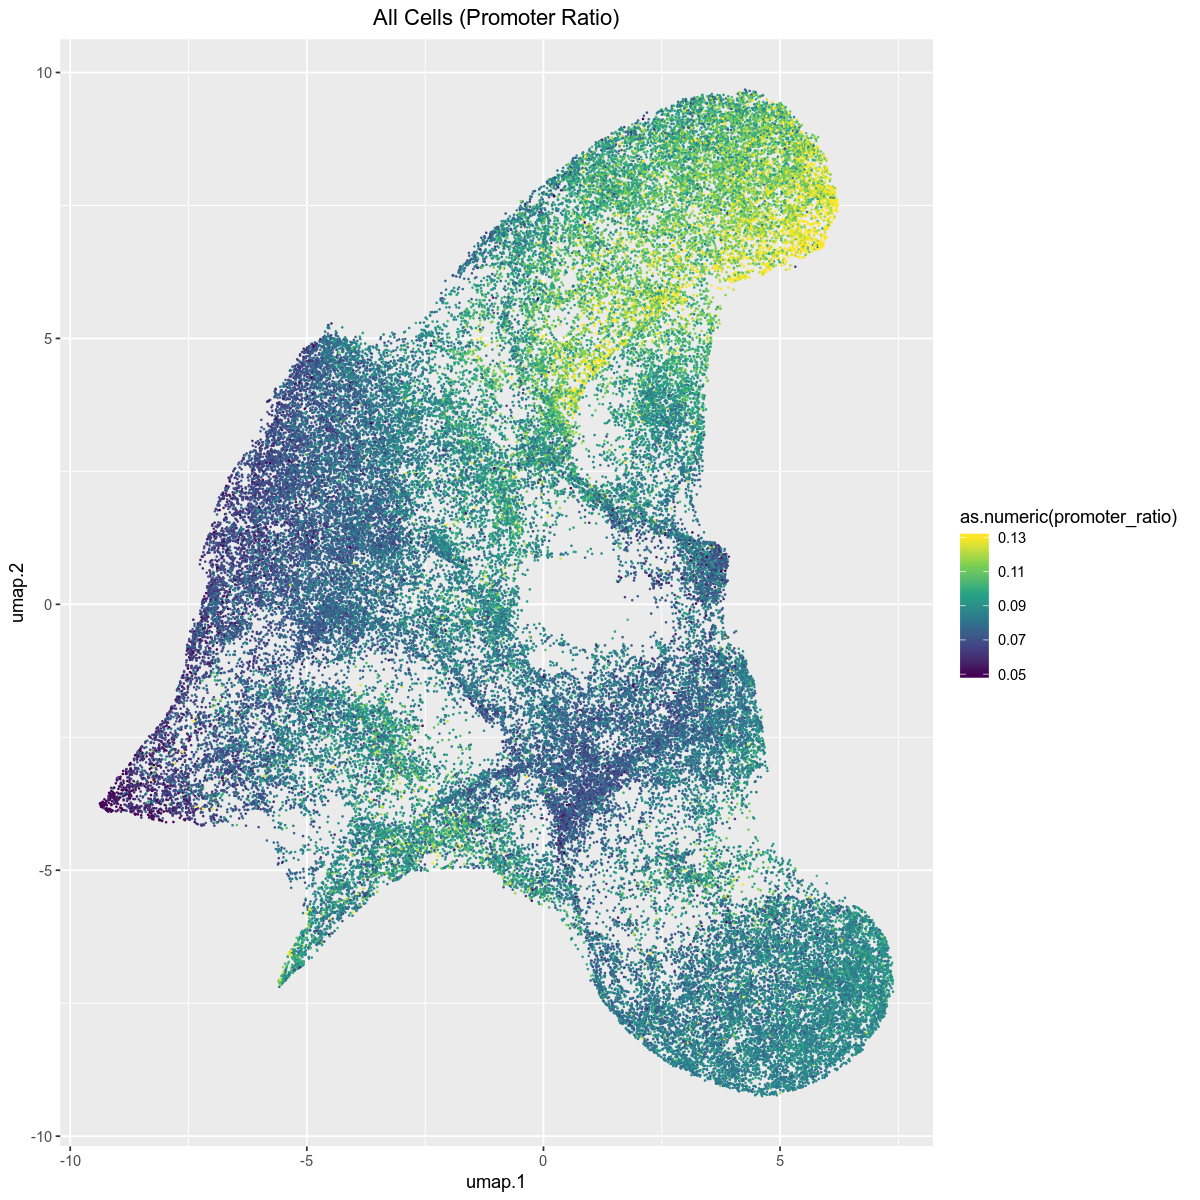

In [160]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(lim=c(0.05,0.13), oob=squish) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

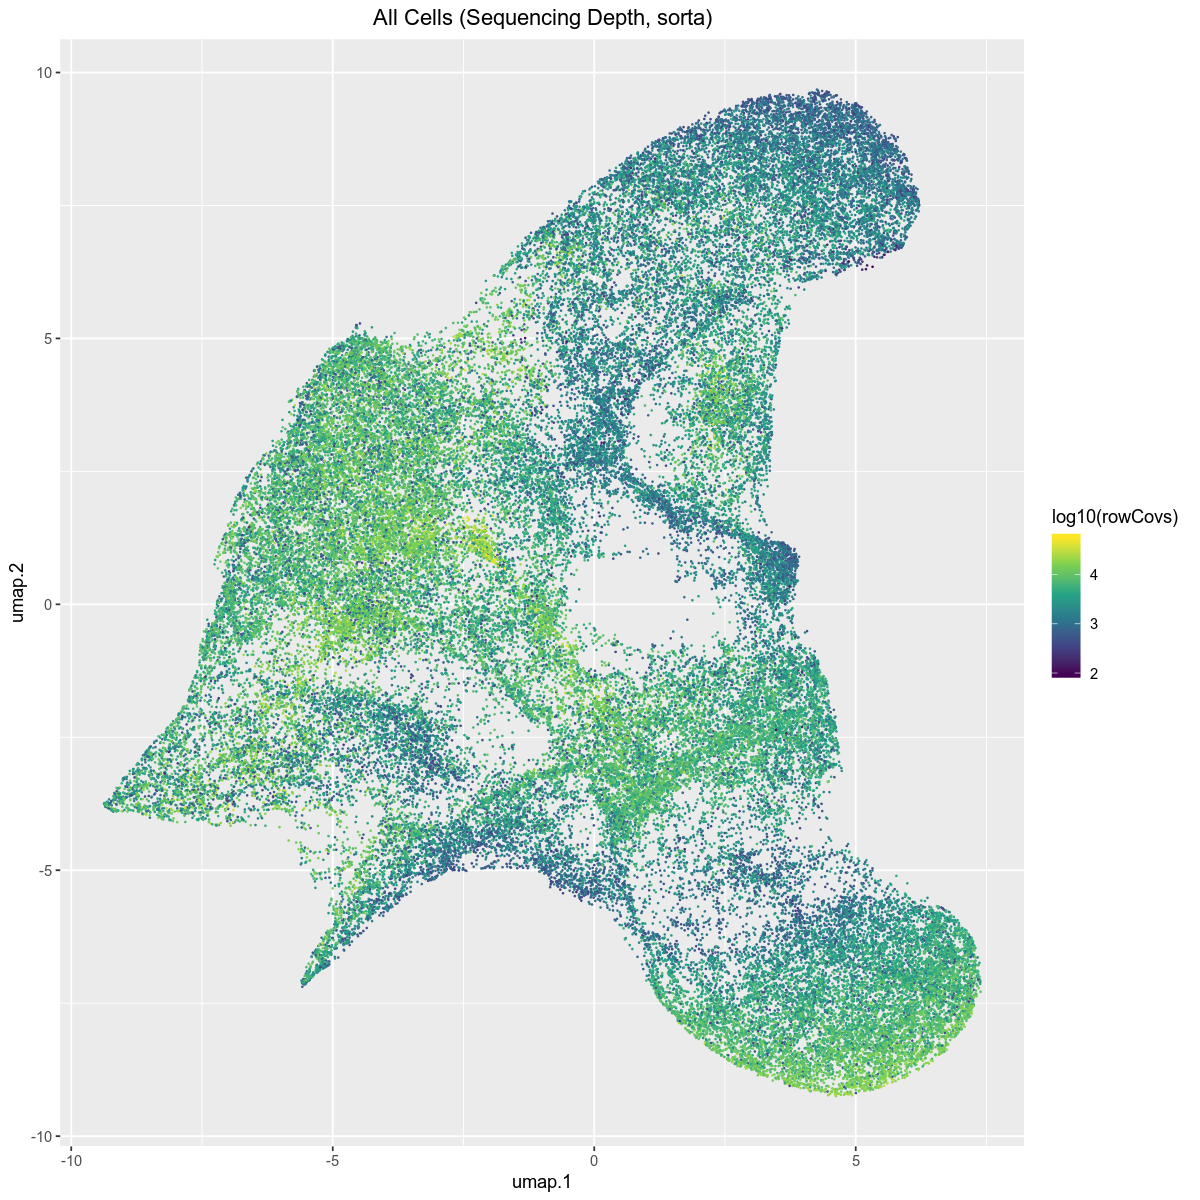

In [156]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

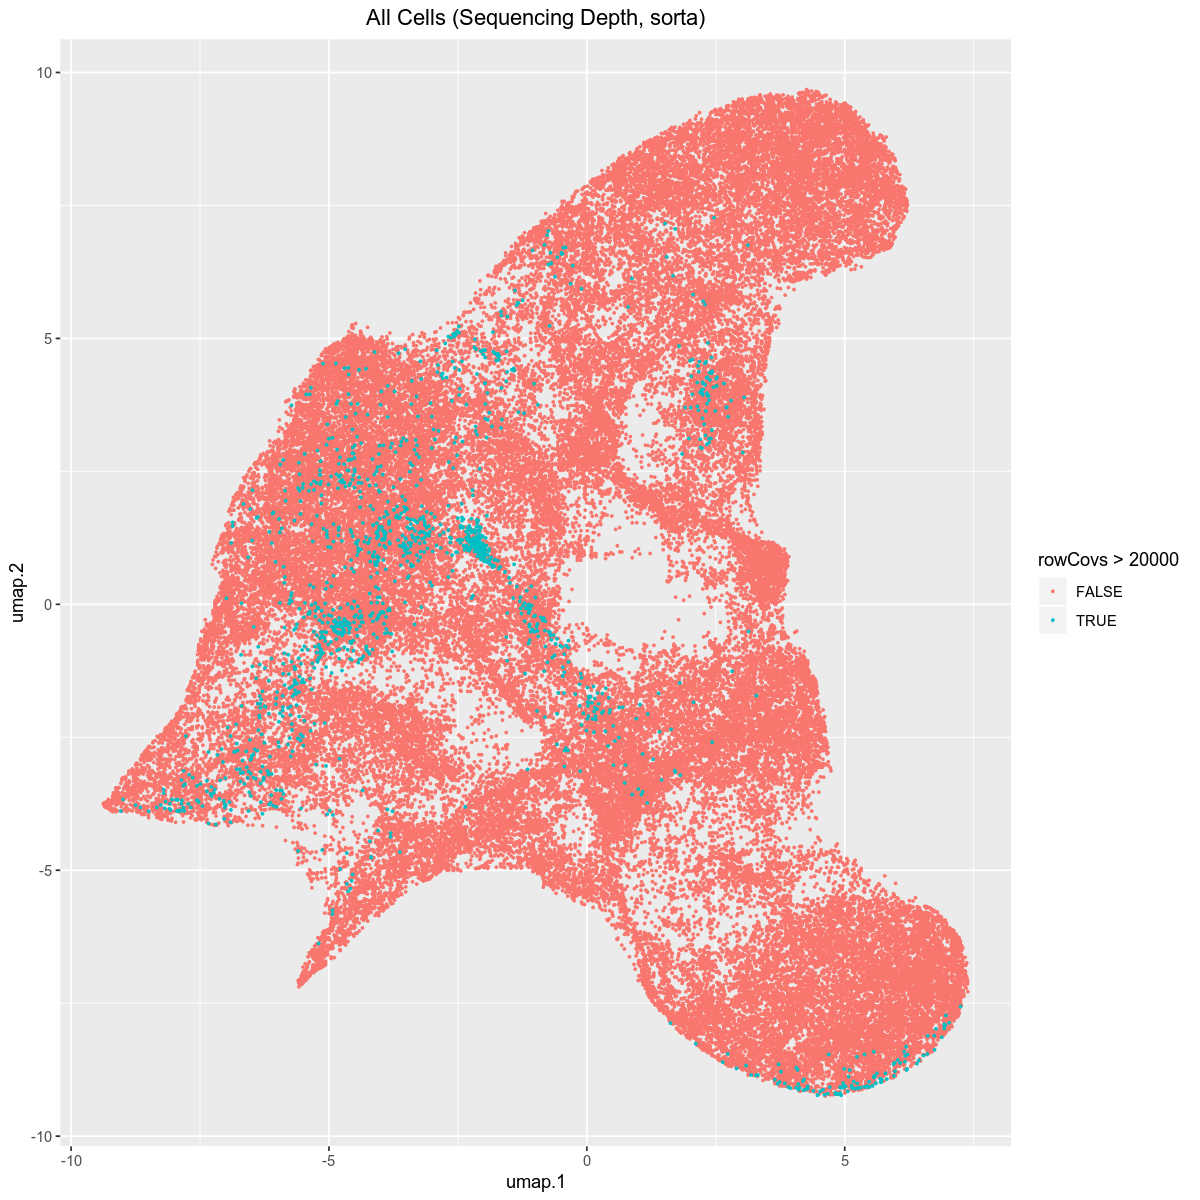

In [424]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[order(rowCovs>20000), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=rowCovs>20000)) +
geom_point(size=0.4, alpha=1) +
# scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

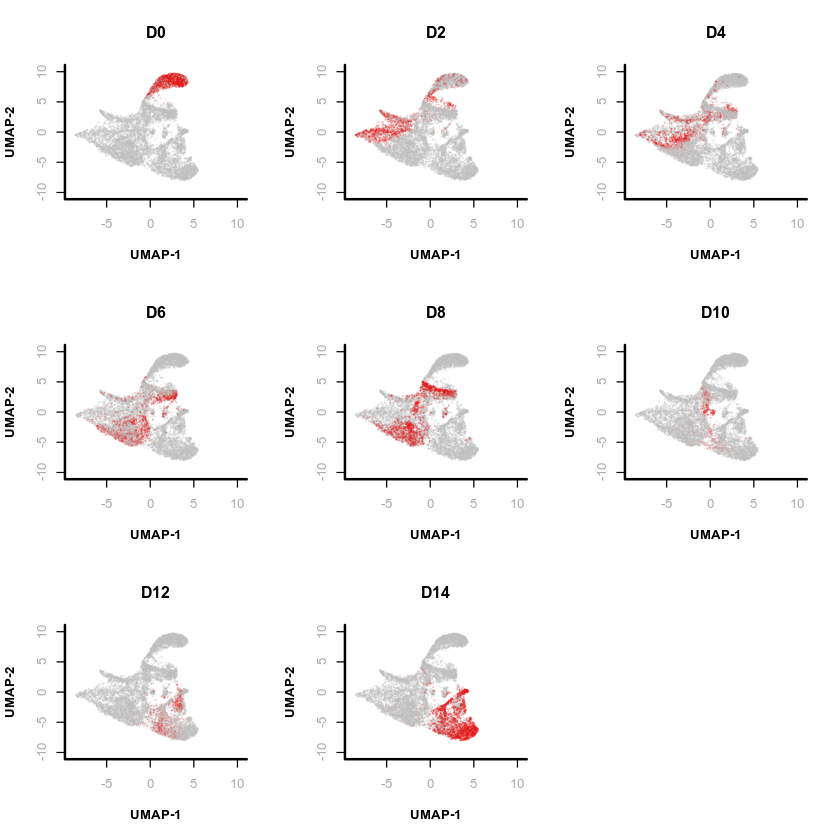

In [47]:
par(mfrow = c(3, 3));
for(d in DAYS){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

## ChromVar

In [ ]:
library(chromVAR)
library(motifmatchr)
library(SummarizedExperiment);
library(BSgenome.Hsapiens.UCSC.hg38);
# library(JASPAR2016)
library(JASPAR2018)
library(TFBSTools)

In [239]:
opts <- list()
opts[["species"]] <- 9606
PFMatrixList <- getMatrixSet(JASPAR2018, opts)

In [240]:
PFMatrixList[[length(PFMatrixList)+1]] = readJASPARMatrix("./data/jaspar/MA0143.4.jaspar")

In [241]:
PFMatrixList

PFMatrixList of length 453
names(453): MA0025.1 MA0030.1 MA0031.1 MA0051.1 ... MA1419.1 MA1420.1 MA1421.1 

In [242]:
# updating getJasparMotifs, which is called by runChromVAR,
# so that it uses Jaspar2018 motifs
getJasparMotifs <- function (collection, species) {
    return(PFMatrixList)
}

In [ ]:
x.sp@mmat = runChromVAR(
    obj=x.sp,
    input.mat="pmat",
    genome=BSgenome.Hsapiens.UCSC.hg38,
    min.count=10,
    species="Homo sapiens"
  );

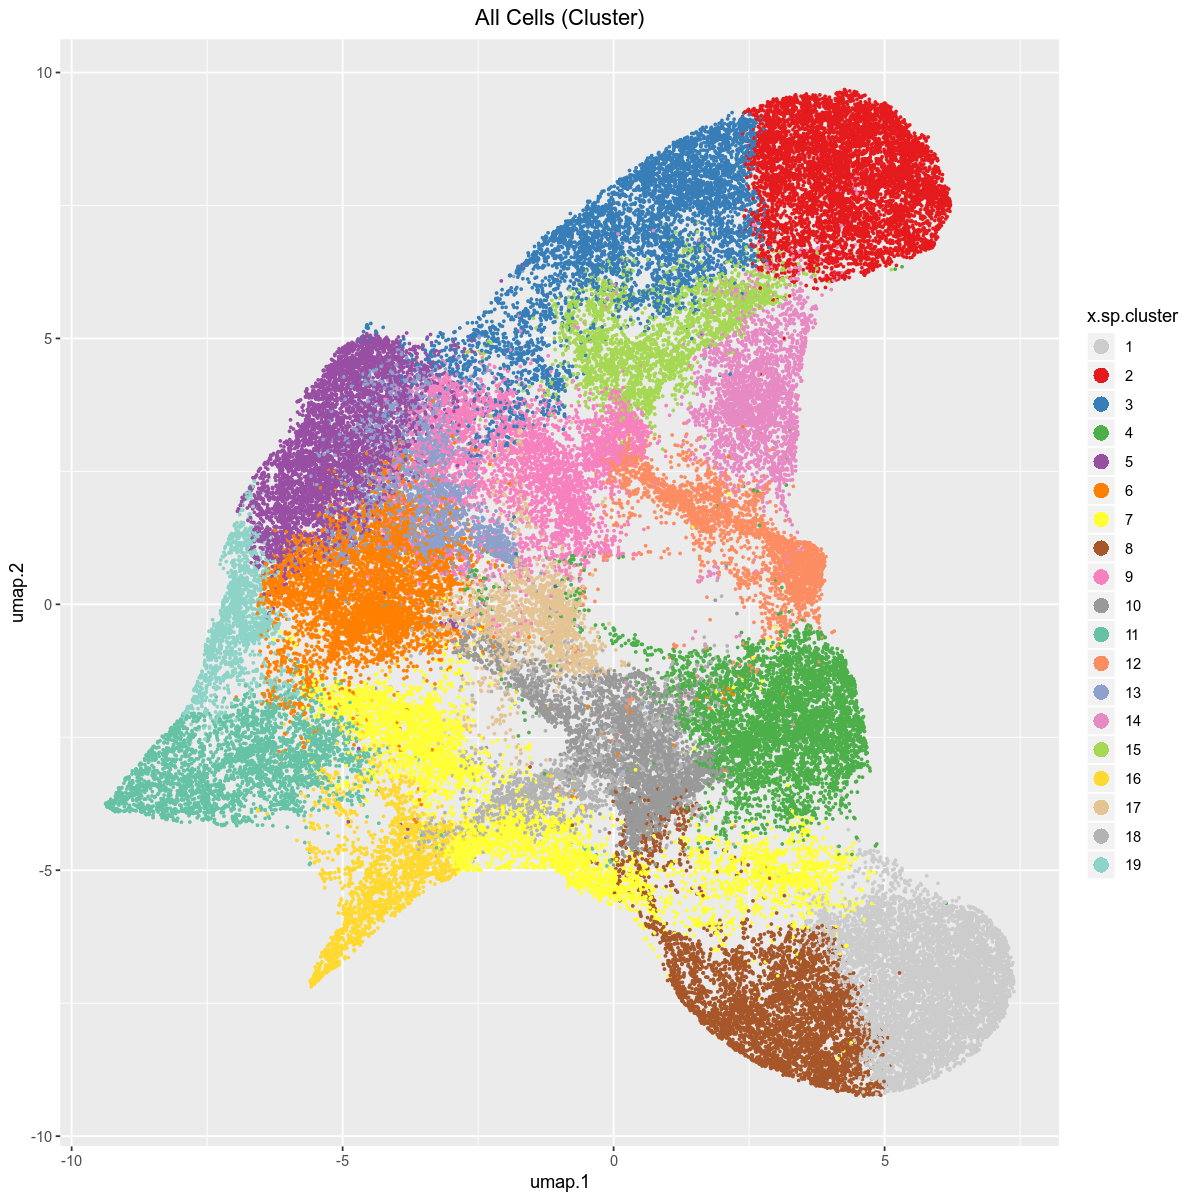

In [348]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.4, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [350]:
table(x.sp@sample[x.sp@cluster=="4"])


  D0  D10  D12  D14   D2   D4   D6   D8 
  34   65   68   65  174 1504 1931 1600 

In [78]:
# write outlier clusters if any
# write.table(x.sp@barcode[(x.sp@cluster=="15")&(x.sp@sample=="D10")], "./out/cluster15_barcode.txt", row.names=F, quote = F, col.names = F)

# barcode list without outliers
for (d in DAYS) {
    write.table(x.sp@barcode[(x.sp@sample==d)&(x.sp@cluster != "15")], 
                sprintf("./barcodeLists/20190220_exclude_clump/%s.barcodes.txt", d),
                row.names = F,
                quote = F,
                col.names = F)
}

In [244]:
table(x.sp@cluster[x.sp@sample=="D2"])


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   0  203  236  232    2    0   42 2521    0   68    0 2504 1387  355    2    0 
  17   18   19 
  59 2065    5 

In [458]:
df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]
colnames(df) = c(colnames(df)[1:4], sub("::", ".", lapply(PFMatrixList, function(x) {return (x@name)})))

ERROR: Error in data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat): arguments imply differing number of rows: 63322, 0


In [ ]:
colnames(df)[grep("CDX", colnames(df))]

In [414]:
var(df[,"PRRX1"])

[1] 0.03391105

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'CDX1' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(cap

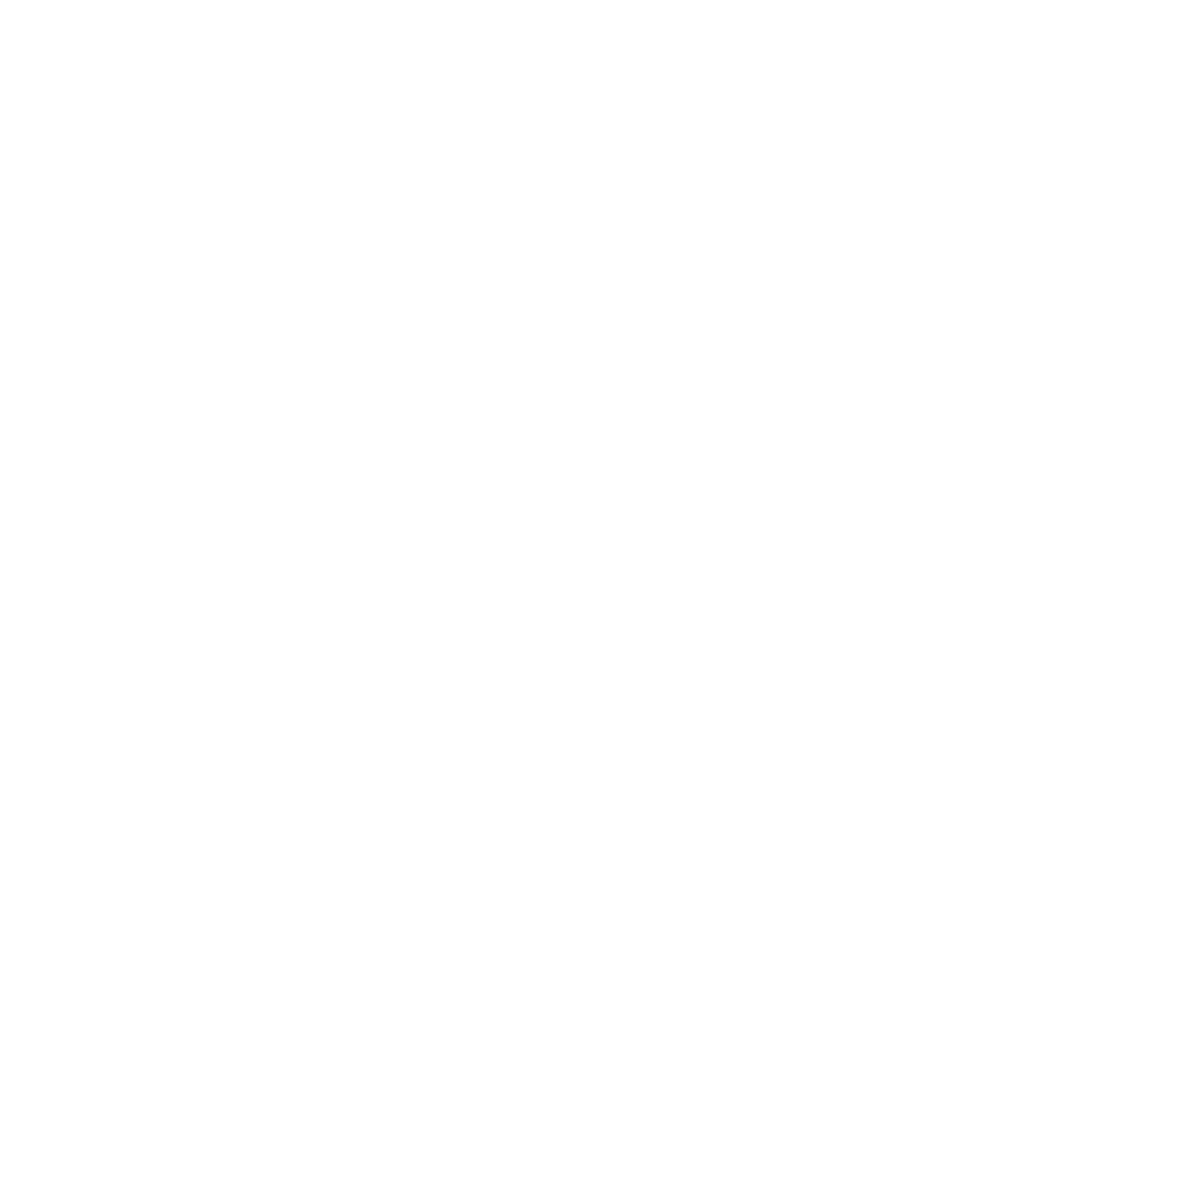

In [456]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df,
# ggplot(df[df$x.sp.sample %in% c("D0", "D2", "D4"),], 
       aes(x=umap.1, y=umap.2, col=CDX1)) +
geom_point(size=0.4, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.6), oob=squish) +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 

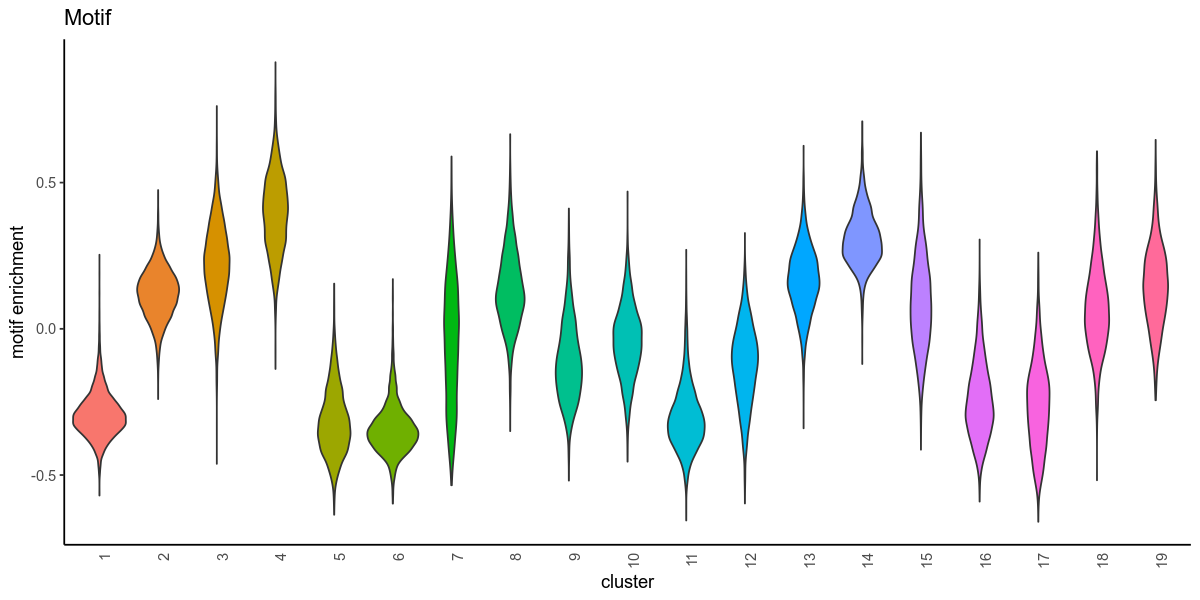

In [344]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df, aes(x=x.sp.cluster, y= FOS.JUN, fill=x.sp.cluster)) + 
    theme_classic() +
    geom_violin() + 
    xlab("cluster") +
    ylab("motif enrichment") + 
    ggtitle("Motif") +
    theme(
#           plot.margin = margin(5,1,5,1, "cm"),
          axis.text.x = element_text(angle = 90, hjust = 1),
          axis.ticks.x=element_blank(),
          legend.position = "none"
);

In [471]:
max(by_cluster[,c("MA0668.1_NEUROD2")])-min(by_cluster[,c("MA0668.1_NEUROD2")])

[1] -0.09358048410 -0.08227930004 -0.07293193552 -0.05033790083 -0.03061087983
 [6] -0.02477623461 -0.01355072309 -0.01047063761 -0.00331939726  0.00007782852
[11]  0.00294719337  0.00748435232  0.01449978995  0.01866087396  0.03568313005
[16]  0.06460323027  0.06640631390  0.09666884675

In [690]:
by_cluster = aggregate(x.sp@mmat,  list(x.sp@cluster), mean)

In [692]:
max_for_cluster = by_cluster[,apply(by_cluster, 2, which.max)=="12"]
length(max_for_cluster)

[1] 60

In [694]:
lapply(strsplit(colnames(max_for_cluster)[rev(order(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))], "_"), "[[", 2)[1:10]

[[1]]
[1] "PHOX2A"

[[2]]
[1] "PROP1"

[[3]]
[1] "CDX1"

[[4]]
[1] "DBP"

[[5]]
[1] "TEF"

[[6]]
[1] "TBX20"

[[7]]
[1] "ZNF410"

[[8]]
[1] "HOXA13"

[[9]]
[1] "TBX19"

[[10]]
[1] "TBX21"

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, function (x) {rev(sort(x))[2]})))

## Write ChromVAR outputs

In [261]:
df = data.frame(x.sp@sample, x.sp@cluster, x.sp@umap, x.sp@mmat)
rownames(df) = paste(x.sp@sample, x.sp@barcode, sep='_')
colnames(df) = c("sample", "cluster", "umap1", "umap2", sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [262]:
dim(df)

[1] 74838   457

In [263]:
head(df)

sample cluster umap1    umap2     NFIL3       FOXF2      
D0_AAACAACGACGATTAC D0     2       6.545686 -7.701751 -0.06097807  0.12900294
D0_AAACAACGACTCACGG D0     2       5.180663 -7.633298  0.26096212  0.03433481
D0_AAACATGGAGACTCGC D0     14      3.282927 -8.525186 -0.10669436  0.06854084
D0_AAACATGGATGGGCCT D0     2       5.934059 -7.776163 -0.10171912  0.10719553
D0_AAACCGTACCTTTAGG D0     14      2.642430 -8.592471 -0.04850392  0.02195831
D0_AAACGAAACCTCGATA D0     14      3.109288 -8.751338 -0.10340678 -0.01207520
                    FOXD1        IRF2         MZF1        MZF1(var.2) ⋯
D0_AAACAACGACGATTAC  0.122682143  0.023708799 -0.03350387 -0.07210584 ⋯
D0_AAACAACGACTCACGG  0.104098022 -0.185325253 -0.08978110 -0.05341638 ⋯
D0_AAACATGGAGACTCGC  0.097844393  0.083130153 -0.05967191 -0.01202470 ⋯
D0_AAACATGGATGGGCCT  0.002820288  0.004389487 -0.06426016 -0.05802489 ⋯
D0_AAACCGTACCTTTAGG -0.016123743 -0.077041036 -0.04410459 -0.03302936 ⋯
D0_AAACGAAACCTCGATA  0.012081353 -0.063036310 -0.06229271 -0.07745096 ⋯
                    RORC        SOX15      TFE3        VDR          
D0_AAACAACGACGATTAC -0.10363258 -0.1276290  0.02889678 -0.0340200459
D0_AAACAACGACTCACGG  0.10424267 -0.2191960  0.17636990 -0.2097924698
D0_AAACATGGAGACTCGC -0.00557459 -0.1212425  0.04607286  0.0019279775
D0_AAACATGGATGGGCCT  0.01462824 -0.1895438  0.01488373  0.0212876103
D0_AAACCGTACCTTTAGG -0.01220366 -0.1826004 -0.03180454  0.0206026068
D0_AAACGAAACCTCGATA -0.09863718 -0.1471419 -0.05464891 -0.0004016025
                    EGR1         IRF3         IRF4       IRF5        
D0_AAACAACGACGATTAC -0.075238083  0.003078155 0.06416149 -0.002606375
D0_AAACAACGACTCACGG -0.008060946 -0.063758849 0.04202541  0.032557515
D0_AAACATGGAGACTCGC -0.003432089 -0.002754538 0.16756656  0.160021886
D0_AAACATGGATGGGCCT -0.060171236 -0.019553484 0.12198716  0.022614238
D0_AAACCGTACCTTTAGG -0.017879214 -0.021853683 0.05807207 -0.037356593
D0_AAACGAAACCTCGATA -0.093914726 -0.042500021 0.05470886 -0.008151317
                    TCF7L1      SOX2      
D0_AAACAACGACGATTAC -0.08757322 -0.2251834
D0_AAACAACGACTCACGG -0.06418007 -0.1404634
D0_AAACATGGAGACTCGC -0.01633408 -0.1156646
D0_AAACATGGATGGGCCT -0.08929770 -0.2130389
D0_AAACCGTACCTTTAGG -0.10338177 -0.1911633
D0_AAACGAAACCTCGATA -0.16273989 -0.2358124

In [264]:
gz = gzfile("./sessions/20200220_n74838/chromvar.tsv.gz", "w")
write.table(df, gz, sep='\t', row.names = T, quote = F)
close(gz)

## Clustering with ChromVAR 

In [1029]:
library(umap)

In [1043]:
df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat)
# shuffle so days don't overlap
colnames(df) = c(colnames(df)[1:4], sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [1044]:
head(df)

umap.1   umap.2    x.sp.cluster x.sp.sample NFIL3       FOXF2      
X   4.772466 -6.667715 2            D0          -0.29156522  0.04831392
X.1 2.130361 -9.291731 8            D0          -0.14924478 -0.02713026
X.2 3.970016 -6.364377 2            D0          -0.17441898  0.70271959
X.3 1.864989 -9.122412 8            D0          -0.06647693  0.02056991
X.4 4.316830 -8.065972 2            D0          -0.02258107  0.18237165
X.5 3.097259 -7.880262 2            D0          -0.36605815 -0.09814538
    FOXD1       IRF2        MZF1        MZF1(var.2) ⋯ RORC        SOX15      
X    0.28102296  0.22136798 -0.03881762 -0.05624360 ⋯  0.08225243 -0.16913721
X.1 -0.08005059 -0.01544193 -0.04508601 -0.07573780 ⋯ -0.09360895 -0.13180443
X.2  0.17100717 -0.14903450 -0.02240269  0.03392831 ⋯  0.17923103  0.06359224
X.3 -0.02776249 -0.07696805 -0.04315734 -0.02941879 ⋯ -0.03131016 -0.17688009
X.4  0.09519949 -0.09202283 -0.03123361 -0.03875528 ⋯ -0.06294978 -0.12409792
X.5 -0.11535767 -0.00924187 -0.08518098 -0.08014815 ⋯ -0.27012123 -0.22186109
    TFE3        VDR         EGR1        IRF3        IRF4        IRF5        
X    0.07303538 -0.10883029 -0.21835569 -0.03517205  0.26295210  0.248802477
X.1  0.07800702 -0.07400591 -0.02444856 -0.02412590  0.08252827 -0.012135779
X.2 -0.32904082 -0.06832553 -0.18014452 -0.08573979 -0.02277189  0.021652037
X.3 -0.02165383  0.02693999 -0.01674927 -0.02504446  0.04404067 -0.039067945
X.4  0.09560575  0.02904725 -0.02827945 -0.07387822  0.12288002  0.073044264
X.5 -0.18973382  0.16969344 -0.04544223 -0.12885476  0.34747333  0.007006643
    TCF7L1      SOX2      
X   -0.11725196 -0.2296258
X.1 -0.06834647 -0.2070722
X.2 -0.15995649 -0.1395883
X.3 -0.10577402 -0.1931231
X.4 -0.15729929 -0.1599006
X.5 -0.20648510 -0.1273571

In [1045]:
chromvar.umap = umap(df[,5:ncol(df)])

In [ ]:
df = data.frame(chromvar.umap$layout, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=X1 , y=X2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [1047]:
library(patchwork)

In [1069]:
df = data.frame(chromvar.umap$layout, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 10000), ]

plots = list()
for (i in seq(1,length(DAYS))) {    
    cur_df = data.frame(df, d = (df$x.sp.sample == DAYS[i]))
    p = ggplot(cur_df) +
    geom_point(size=0.1, alpha=1, aes(x=X1 , y=X2, col=d)) +
    ggtitle(DAYS[i]) + 
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none") 
    # ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
    #                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))
    
    plots[[i]] = p
}

In [ ]:
wrap_plots(plots)

In [ ]:
df = data.frame(chromvar.umap$layout, x.sp@mmat)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]
colnames(df) = c(colnames(df)[1:2], sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [1116]:
colnames(df)[grep("TCF", colnames(df))]

[1] "TAL1-TCF3" "CTCF"      "TCF7L2"    "TCF3"      "TCF4"      "CTCFL"    
[7] "TCF7L1"

In [ ]:
ggplot(df,
# ggplot(df[(df$x.sp.sample=="D2"),], 
       aes(x=X1, y=X2, col=TCF4)) +
geom_point(size=0.4, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.5), oob=squish) +
# scale_color_viridis_c() +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 

## Write Fragment for each cluster (UNTESTED FOR pmat)

In [290]:
writeClusterFragmentsToBed <- function(
    obj, 
    output.prefix,
    path.to.snaptools,
    buffer.size=500,
    num.cores=10
){
    fileList = as.list(unique(obj@file));
 
    # check if files are all snap files
    if(any(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)
        print("error: these files are not snap file")
        print(fileList[idx])
        stop()
    }
    
    # check if FM session exist
    if(any(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)
        print("error: the following nsap files do not contain FM session")
        print(fileList[idx])
        stop()
    }
        
    # write the following barcodes down
    barcode.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".barcode.txt");
    })

    bed.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".bed.gz");
    })
    
    # write down the barcodes
    cat("Epoch: extracting fragments from each snap files ...\n", file = stderr())
    flag.list = lapply(seq(fileList), function(i){
        file.name = fileList[[i]];
        idx = which(obj@file == file.name);
        barcode.use = obj@barcode[idx]
        message(barcode.files[[i]])
        message(bed.files[[i]])
        message(fileList[[i]])
        write.table(barcode.use, file = barcode.files[[i]], append = FALSE, quote = FALSE, sep = "\t",
                         eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                         col.names = FALSE, qmethod = c("escape", "double"),
                         fileEncoding = "")
        
    })

    # extract the fragments belong to the barcodes    
    flag.list = mclapply(seq(fileList), function(i){
        flag = system2(command=path.to.snaptools, 
            args=c("dump-fragment", 
                   "--snap-file", fileList[[i]], 
                   "--output-file", bed.files[[i]], 
                   "--barcode-file", barcode.files[[i]],
                   "--buffer-size", buffer.size
                   )        
            )                
    }, mc.cores=num.cores);
    
    # combine these bed files
    combined.bed = paste(output.prefix, ".bed.gz");
    flag = system2(command="cat", 
        args=c(paste(bed.files, collapse = ' '),
               ">", combined.bed
               )        
        )                
}

In [ ]:
cluster_names = names(table(x.sp@cluster))
# mclapply(seq(cluster_names), function(i){
#     print(cluster_names[i]);
#     writeClusterFragmentsToBed(
#         obj=x.sp[which(x.sp@cluster==cluster_names[i]),], 
#         output.prefix=paste0("./snapATAC_sessions/20200125_n76770/cluster_beds/idx", cluster_names[i]),
#         path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
#         buffer.size=500, 
#         num.cores=1
#    );
#  }, mc.cores=5);

## Export Meta Data for Session (UNTESTED FOR pmat)

In [263]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./snapATAC_sessions/20200125_n76770/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))

In [53]:
write.table(x.sp@smat@dmat, "./snapATAC_sessions/20200125_n76770/eig_mat.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [74]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp@feature),
                       starts=start(x.sp@feature)-1,
                       ends=end(x.sp@feature)),
            file="./snapATAC_sessions/20200125_n76770/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [16]:
writeMM(x.sp@bmat, file="./snapATAC_sessions/20200125_n76770/5kb.sparse.mm")

NULL

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL